In [138]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [191]:
train_size = 0.8
val_size = 0.2

In [176]:
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    
    return torch.round(tensor)


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1))
])

def add_noise(img_tensor, std=0.5, mean=0):
    return img_tensor + torch.rand(img_tensor.size()) * std + mean

In [193]:
train_data  = torchvision.datasets.MNIST("./data", train=True, transform=img_transform, download=False)
test_data = torchvision.datasets.MNIST("./data", train=False, transform=img_transform, download=False)

data_size = len(train_data)

In [194]:
len(train_data), len(test_data)

(60000, 10000)

In [195]:
generator = torch.Generator().manual_seed(42)
train_set, val_set = torch.utils.data.random_split(train_data, [int(train_size*data_size), int(val_size*data_size)], generator=generator)

In [196]:
len(train_set), len(val_set)

(48000, 12000)

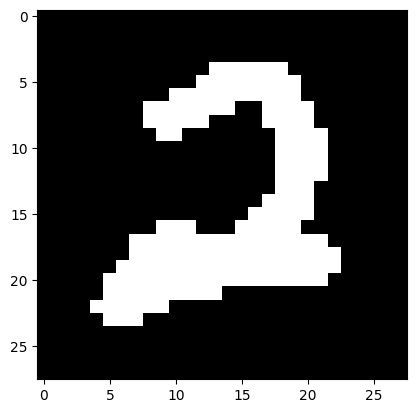

In [197]:
j = 8
x, _ = train_set[j]
plt.imshow(x.numpy()[0], cmap='gray')

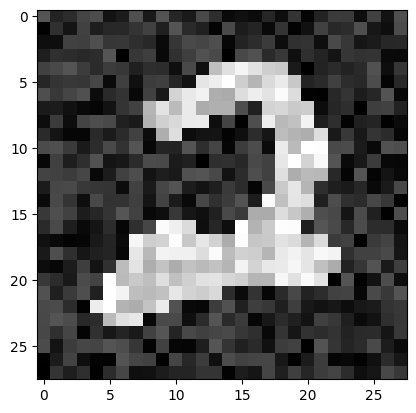

In [198]:
x , _= train_set[j] # x is now a torch.Tensor
plt.imshow(add_noise(x).numpy()[0], cmap='gray')

In [202]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.l = nn.Linear(10, 10)

    def forward(self, x):
        return x

In [203]:
model = AutoEncoder()

In [204]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)